# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import re #regular expression

import matplotlib.pyplot as plt #For plotting graphs
import matplotlib.ticker as mtick
#plt.style.use('ggplot')
#include plots in the notebook
%matplotlib inline 
import seaborn as sns #For plotting graphs
#sns.set(style='darkgrid')
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder #for creating dummy variables out of categorical variables
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, \
confusion_matrix, mean_squared_error, balanced_accuracy_score,roc_curve
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from scipy.stats import chi2_contingency

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

# Undersampling and Oversampling Libraries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour,TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

# Recursive Feature Elimination
from probatus.feature_elimination import ShapRFECV

#utilities
import collections

import warnings
warnings.filterwarnings("ignore")

import shap
shap.initjs()

from LGBMBayesianOptimization import bayes_parameter_opt_lgb
from functions import plot_auc1, plot_auc2, performance_metrics

pd.set_option('display.max_colwidth', None)

# Read data exported from Step1 EDA

In [2]:
df_woe = pd.read_csv('df_woe.csv')

In [3]:
df_iv = pd.read_excel("VariablesSummary.xlsx")

# Remove variables with IV>1

Remove variables that are either suspiciously too good in predicting the label. Typically, if IV is above 0.5 then it needs to be inspected for its independence in relation to the target variable. There could be performance leakage

In [4]:
remove_features = list(df_iv[df_iv['IV']>=1]['FeatureName'])
remove_features_woe = [x+'_woe' for x in remove_features]
remove_features.extend(remove_features_woe)
print("Number of selected features: ",len(remove_features))

Number of selected features:  10


In [5]:
df_woe.drop(columns=remove_features,inplace=True)

# Develop a benchmark model using LGBM

Develop a benchmark bossted tree model using all selected raw variables to assess how strong the model can get. LGBM assigns NaN to the missing values and gives them their own node.

In [6]:
data = df_woe.copy()

y = data.label
X = data.drop(columns='label')

X["feature_8"] = X["feature_8"].astype("category")

### Convert the categorical variables to dummy variables

In [7]:
# Divide the data into training and testing datasets
# stratified sampling: same percentage from each class
X_train, X_val, y_train, y_val = train_test_split(X, y,stratify=y, test_size=.25, random_state=42)
X_train.shape, X_val.shape

((4500, 1303), (1500, 1303))

In [8]:
# Create train and validation datasets to include the target variable
df_train = pd.merge(X_train,y_train,left_index=True,right_index=True)
df_val = pd.merge(X_val,y_val,left_index=True,right_index=True)

In [9]:
#create a dictionary with feature name and type "numerical" or "categorical". This will be used by the optbinning process
cat_cols = list(X.select_dtypes(include='category').columns)
cat_cols

['feature_8']

In [10]:
from LGBMBayesianOptimization import bayes_parameter_opt_lgb
opt_res, opt_params = bayes_parameter_opt_lgb(X_train, y_train, categorical_feats = cat_cols, init_round=15, \
                                              opt_round=15, n_folds=3, random_seed=42, n_estimators=1000)
opt_res, opt_params

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | min_sp... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.8851    | 0.9888    | 0.1253    | 3.477     | 3.5       | 0.1549    | 8.519     | 45.13     | 6.334     | 0.4239    | 0.00357   | 44.93     |
[200]	cv_agg's auc: 0.900729 + 0.00760322
| 2         | 0.9015    | 0.9529    | 0.6943    | 3.506     | 3.828     | 0.01159   | 11.04     | 27.97     | 6.634     | 0.3213    | 0.008894  | 40.07     |
| 3         | 0.8966    | 0.9762    | 0.5148    | 2.359     | 4.152     | 0.1645    | 6.736     | 34.94     | 13.1      | 0.1806    | 0.006528  | 40.56     |
[200]	cv_agg's auc: 0.900713 + 0.00876225
| 4         | 0.9011    | 0.9679    | 0.5356    | 3.855     | 0.6014    | 0.02203   | 8.963     | 18.61     | 10.25     | 0.09

(0.9042279455848589,
 {'bagging_fraction': 0.8,
  'feature_fraction': 0.9,
  'lambda_l1': 0.0,
  'lambda_l2': 5.0,
  'learning_rate': 0.01,
  'max_depth': 12.0,
  'min_child_weight': 14.942782461394257,
  'min_data_in_leaf': 5.0,
  'min_split_gain': 0.001,
  'min_sum_hessian_in_leaf': 1e-05,
  'num_leaves': 15.0})

In [11]:
param_dict = opt_params
seed=42

param_lgb = {
        'num_leaves': int(param_dict['num_leaves']),
        'min_data_in_leaf': int(param_dict['min_data_in_leaf']), 
        'learning_rate':param_dict['learning_rate'],
        'min_sum_hessian_in_leaf': param_dict['min_sum_hessian_in_leaf'],
        'bagging_fraction': param_dict['bagging_fraction'], 
        'feature_fraction': param_dict['feature_fraction'],
        'lambda_l1': param_dict['lambda_l1'],
        'lambda_l2': param_dict['lambda_l2'],
        'min_gain_to_split': param_dict['min_split_gain'],
        'max_depth': int(param_dict['max_depth']), 
        'save_binary': True,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False
    }


xg_train = lgb.Dataset(X_train,categorical_feature=cat_cols,
                       label=y_train.ravel(),
                       free_raw_data = False
                       )
xg_valid = lgb.Dataset(X_val,categorical_feature=cat_cols,
                       label=y_val.ravel(),
                       free_raw_data = False
                       )   

clf_lgb_new = lgb.train(param_lgb, xg_train,1000, valid_sets = [xg_valid], verbose_eval=200, early_stopping_rounds = 100)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.901523
Early stopping, best iteration is:
[168]	valid_0's auc: 0.90257


In [12]:
# Score
pred_y_lgb_val = clf_lgb_new.predict(X_val.values, num_iteration=clf_lgb_new.best_iteration)   

### Evaluate Model

In [13]:
def performance_metrics(y_true, y_pred, threshold=0.5):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    y_pred_bin = np.round(y_pred)
    #y_pred_bin = [0 if y < threshold else 1 for y in y_pred]
    d={}
    d['accuracy'] = accuracy_score(y_true, y_pred_bin)
    d['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred_bin)
    d['precision'] = precision_score(y_true, y_pred_bin)
    d['recall'] = recall_score(y_true, y_pred_bin)
    d['RMSE'] = mean_squared_error(y_true, y_pred, squared=False)
    cm = confusion_matrix(y_true, y_pred_bin)
    cm = pd.DataFrame(cm, index=[['Observed','Observed'],['False','True']],\
                      columns=[['Predicted','Predicted'],['False','True']])
    text = 'Performance Metrics\n'
    p = 20
    for i,j in d.items():
        text += '\n{}{} = {:.3f}'.format(i.title(),' '*(p-len(i)),j)
    print(text,'\n\nConfusion Matrix')
    return cm

def plot_roc(y_true,y_pred,model_name='Model'):
    y_true = np.ravel(y_true)
    # for i in array of y_pred
    y_pred = np.ravel(y_pred)
    fpr,tpr,thresholds = roc_curve(y_true,y_pred)
    ks = max(tpr-fpr)
    AUC = roc_auc_score(y_true,y_pred)
    plt.plot(fpr,tpr,color='tab:blue',label='{}\nAUC = {}\nKS = {}'.format(model_name,round(AUC,3),round(ks,3)))
    
    plt.plot([0,1],[0,1],linestyle='--',color='black',label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    return

In [14]:
performance_metrics(y_val,pred_y_lgb_val)

Performance Metrics

Accuracy             = 0.836
Balanced_Accuracy    = 0.852
Precision            = 0.441
Recall               = 0.874
Rmse                 = 0.360 

Confusion Matrix


Predicted     
                   False True
Observed False      1080  221
         True         25  174

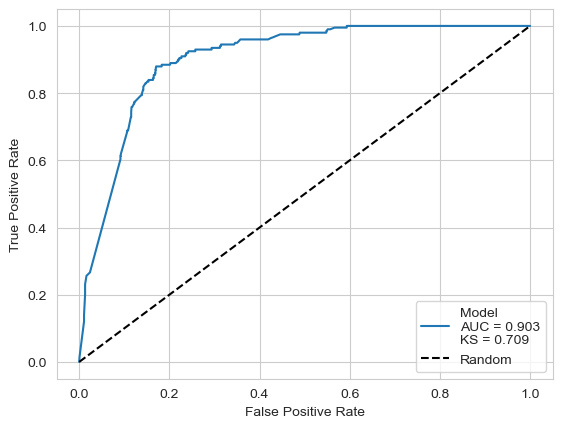

In [15]:
plot_roc(y_val,pred_y_lgb_val)

# Recursive Feature Elimination

#### Logistic Regression based RFE

First we will develop a Logistic Regression model to develop a baseline expectation for performance metric. AUC_ROC metric is chosen as the performance metric.

In [16]:
X_train = X_train.drop(columns='feature_8')
X_val = X_val.drop(columns='feature_8')

In [17]:
data = X.copy()
total = data.isnull().sum().sort_values(ascending=False)
percent = round((data.isnull().sum()/data.isnull().count()*100),2).sort_values(ascending=False)
count = data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent, count], axis=1, keys=['MissingTotal', 'MissingPercent', 'Total'])
missing_data[missing_data['MissingPercent']>0].head(100)

,MissingTotal,MissingPercent,Total
feature_3,4799,79.98,6000
feature_12,69,1.15,6000


In [18]:
X_train = X_train.drop(columns=['feature_3','feature_12'])
X_val = X_val.drop(columns=['feature_3','feature_12'])

In [19]:
X.shape

(6000, 1303)

In [20]:
# clf_lr = LogisticRegression(n_jobs=-1,random_state=42)

clf_lgbm = LGBMClassifier(max_depth=10, class_weight='balanced')

param_grid = {
    'n_estimators': [5, 7, 10,20],
    'num_leaves': [3, 5, 7, 10],
}
search = HalvingGridSearchCV(clf_lgbm, param_grid)

shap_elimination = ShapRFECV( clf=search, step=0.2, cv=3, scoring='roc_auc', n_jobs=-1) 
report = shap_elimination.fit_compute(X_train, y_train)

In [45]:
report.to_excel('rfe.xlsx')

In [21]:
report[['num_features', 'features_set', 'train_metric_mean','val_metric_mean']]

,num_features,features_set,train_metric_mean,val_metric_mean
1,1300,"[feature_1, feature_5, feature_6, feature_7, feature_9, feature_11, account_c, account effective_c, ach_c, ach deposit_c, ach payment_c, ach payment id_c, achdw_c, ally_c, ally checking_c, amazon_c, amazon com_c, amazon com billnj_c, amazon mktp_c, amazon mktp u_c, amazon prime_c, amazon tip_c, americanexpress_c, americanexpress ach_c, americanexpress ach payment_c, amiya_c, amiya support_c, amiya support chownnj_c, apartment_c, apartment web_c, apartment web payment_c, apple_c, apple com_c, apple com ca_c, applecard_c, applecard gsbank_c, applecard gsbank payment_c, arco_c, atm_c, atm withdrwl_c, atmfeereimbusement_c, audible_c, autopay_c, autopay id_c, autopay id indn_c, avenue_c, avenue newyork_c, avenue newyork ny_c, b_c, banking_c, banking transfer_c, banking transfer chk_c, banking transfer conf_c, banking transfer sav_c, bankofamerica_c, bankofamerica atm_c, bankofamerica atm withdrwl_c, bankofamerica credit_c, bankofamerica credit account_c, barclaycard_c, barclaycard u_c, barclaycard u creditcard_c, bike_c, bike com_c, bike com ca_c, billnj_c, binan_c, binan future_c, binan future tran_c, brooklyn_c, brooklyn ny_c, bv_c, bv iat_c, bv iat paypal_c, c_c, c ocrolus_c, c ocrolus directdeposit_c, ca_c, ca recurring_c, capital_c, capital grou_c, capital grou web_c, card_c, cashout_c, cashout id_c, cashout id indn_c, cava_c, cava jersey_c, cava jersey city_c, change_c, change transfer_c, change transfer account_c, chase_c, chase creditcard_c, chase creditcard autopay_c, chase creditcard epay_c, check_c, checkcard_c, checkcard amazon_c, checkcard amazon com_c, ...]",0.837,0.819
2,1040,"[memorial sloan_tf, kirsten nicassio ppd_tf, pay id_tf, james peter ppd_c, info_c, u_c, autopay id indn_tf, amazon tip_tf, whse purchase_c, dig inn madison_tf, banking transfer conf_c, nicassio kirsten_tf, chk_tf, paymentrec id_tf, fooddelivery help_tf, j hwang web_tf, kristen s_tf, visa direct_tf, nyct_tf, billnj_c, transfer sav confirmation_tf, credit account_c, ryan gosling_tf, venmo payment id_tf, online banking_tf, payment id indn_c, checkcard amazon com_c, online saving account_c, spectrum_tf, san_tf, rideshare_c, nyct paygo_tf, conf_c, paypal inst transfer_tf, elan_c, feature_1_woe, amazon mktp u_tf, deposit mobile_tf, james_tf, nicassio ppd_tf, grou web_c, grill flt_c, san_c, jonathan j_tf, finastra usa_c, sloan_tf, kirsten l_tf, mta_c, newyork waterway nj_tf, grill flt_tf, kristen nicassio web_tf, venmo payment_c, plano_c, indn kirsten_c, city_tf, payment id indn_tf, httpswww_tf, amiya support chownnj_c, purchase fooddelivery_c, inst transfer id_tf, transfer checking account_tf, plano tx_c, prime_c, e payment id_tf, purchase newyork_c, transfer sav_c, zelle payment_tf, card_tf, trip help comca_tf, nicassio kirsten l_c, internet_tf, help comca_tf, rideshare citi bike_c, indn jonathan j_c, mcdonald kristen_tf, id r indn_c, grou web payment_c, online saving_tf, whse_tf, gusto pay id_c, web payment id_tf, indn missnicassio_tf, apartment web_c, gsbank payment_c, veggie_c, peter_tf, transfer id_c, tx_c, hwang jonathan ppd_c, checkcard starbucks wa_c, id indn ryan_tf, venmo cashout id_c, grou_tf, visa direct ny_tf, checking account_c, citi_c, fee_c, jonathan j_c, com ca_c, help_c, ...]",0.837,0.819
3,832,"[memorial sloan_tf, kirsten nicassio ppd_tf, pay id_tf, james peter ppd_c, info_c, u_c, autopay id indn_tf, amazon tip_tf, whse purchase_c, dig inn madison_tf, banking transfer conf_c, nicassio kirsten_tf, chk_tf, paymentrec id_tf, fooddelivery help_tf, j hwang web_tf, kristen s_tf, visa direct_tf, nyct_tf, billnj_c, transfer sav confirmation_tf, credit account_c, ryan gosling_tf, venmo payment id_tf, online banking_tf, payment id indn_c, checkcard amazon com_c, online saving account_c, spectrum_tf, san_tf, rideshare_c, nyct paygo_tf, conf_c, paypal inst transfer_tf, elan_c, feature_1_woe, amazon mktp u_tf, deposit mobile_tf, james_tf, nicassio ppd_tf, grou web_c, san_c, gr

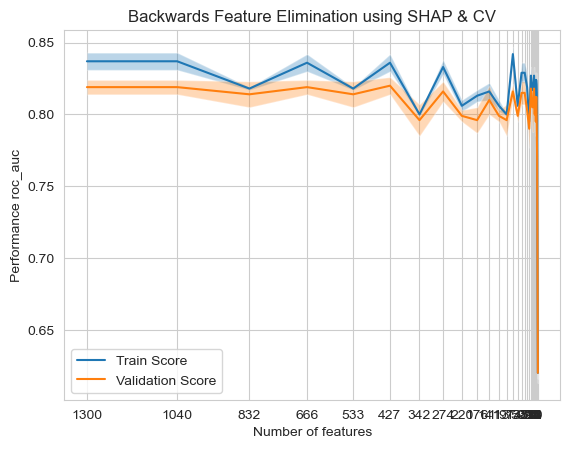

In [22]:
performance_plot = shap_elimination.plot()

1. From the table and the chart above, the validation AUC ROC starts flatenning 81.2%. So we choose the least number of variables that gives us that AUC ROC.

In [23]:
list_lr = shap_elimination.get_reduced_features_set(num_features=5)
list_lr

['feature_1', 'feature_7', 'feature_6_woe', 'feature_3_woe', 'feature_5']

In [24]:
# Calculate variance inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# extracting the numerical columns

# VIF dataframe
vif_data = pd.DataFrame()
vif_data['Feature'] = X[list_lr].columns
  
# calculating VIF for each feature
vif_data['VIF_Train']= [variance_inflation_factor(X_train[list_lr].values, i) for i in range(len(X_train[list_lr].columns))]
vif_data['VIF_Val']= [variance_inflation_factor(X_val[list_lr].values, i) for i in range(len(X_val[list_lr].columns))]

# printing the VIF of each feature
print(vif_data)

         Feature  VIF_Train   VIF_Val
0      feature_1   1.021987  1.015013
1      feature_7   1.011006  1.012344
2  feature_6_woe   1.010742  1.012674
3  feature_3_woe   1.055494  1.064471
4      feature_5   1.060113  1.056448


Variance Inflation factor of < 10 shows that there is no co-variance betweent the variables.

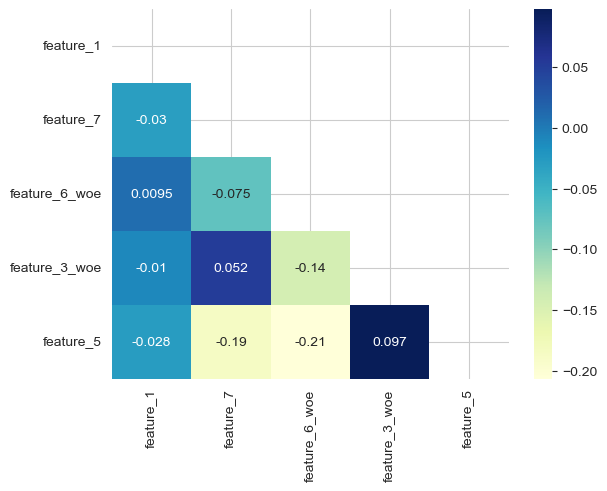

In [25]:
mask = np.triu(np.ones_like(X_train[list_lr].corr()))
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(X_val[list_lr].corr(), cmap="YlGnBu", annot=True, mask=mask)
# displaying heatmap
plt.show()

The pairwise correlations between the chosen variables are also below 0.5 indicating that the variables are independent of each other.

# Compare different model algorithms and sampling techniques

In [26]:
model_name = []
resample = []
AUCROC_train = []
AUCROC_val = []

In [27]:
def test_eval(clf_model, X_train,y_train, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob_train=clf_model.predict_proba(X_train)[:,1]
    y_prob_test=clf_model.predict_proba(X_test)[:,1]
   
    model_name.append(algo)
    resample.append(sampling)
    AUCROC_train.append(roc_auc_score(y_train, y_prob_train)) 
    AUCROC_val.append(roc_auc_score(y_test, y_prob_test)) 

In [28]:
classifiers = {"Logistic" : LogisticRegression(n_jobs=-1),
                "KNeighborsClassifier" : KNeighborsClassifier(n_jobs=-1),
               "LGBM" : LGBMClassifier(n_jobs=-1),
               "RandomForest" : RandomForestClassifier(n_jobs=-1)
              }
sampling_methods = {"None": None,
                    "SMOTE" : SMOTE(),
                    "SMOTEENN" : SMOTEENN(),
                    "TomekLinks": TomekLinks(),
                    "NearMiss" : NearMiss()
                   }
for sampling_method in sampling_methods:
    if sampling_method != "None":
        
        method = sampling_methods[sampling_method]
        X_resamp, y_resamp = method.fit_resample(X_train[list_lr], y_train)
        for classifier in classifiers:           
            model = classifiers[classifier]
            model.fit(X_resamp, y_resamp)
            test_eval(model, X_train[list_lr], y_train, X_val[list_lr], y_val, classifier, sampling_method)
    elif sampling_method == "None":
        for classifier in classifiers:
            model = classifiers[classifier]
            model.fit(X_train[list_lr], y_train)
            test_eval(model, X_train[list_lr], y_train, X_val[list_lr], y_val, classifier, "None")

In [29]:
clf_eval_df = pd.DataFrame({'model':model_name,
                            'resample':resample,
                            'aurroc_train':AUCROC_train,
                            'aurroc_val':AUCROC_val})
clf_eval_df = clf_eval_df.sort_values(by=['aurroc_val'],ascending=False)
clf_eval_df

,model,resample,aurroc_train,aurroc_val
2,LGBM,None,0.892772,0.813460
6,LGBM,SMOTE,0.881850,0.805610
14,LGBM,TomekLinks,0.893145,0.802409
10,LGBM,SMOTEENN,0.854231,0.771299
7,RandomForest,SMOTE,0.974351,0.749236
15,RandomForest,TomekLinks,0.967810,0.741588
3,RandomForest,None,0.981851,0.738558
11,RandomForest,SMOTEENN,0.838089,0.714425
5,KNeighborsClassifier,SMOTE,0.893247,0.690368
1,KNeighborsClassifier,None,0.884830,0.685437


1. LGBM outperforms all other chosen algorithms
2. Among the sampling technqiues, no-sampling gives the best result

Therefore, for final model, LGBM with no-sampling is chosen

# Final Model

In [30]:
X_train = X_train[list_lr]
X_val = X_val[list_lr]

In [31]:
opt_res, opt_params = bayes_parameter_opt_lgb(X_train, y_train, categorical_feats = None, init_round=15, \
                                              opt_round=15, n_folds=3, random_seed=42, n_estimators=1000)
opt_res, opt_params

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | min_sp... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7975    | 0.9888    | 0.1253    | 3.477     | 3.5       | 0.1549    | 8.519     | 45.13     | 6.334     | 0.4239    | 0.00357   | 44.93     |
[200]	cv_agg's auc: 0.818064 + 0.00721176
| 2         | 0.8189    | 0.9529    | 0.6943    | 3.506     | 3.828     | 0.01159   | 11.04     | 27.97     | 6.634     | 0.3213    | 0.008894  | 40.07     |
| 3         | 0.8152    | 0.9762    | 0.5148    | 2.359     | 4.152     | 0.1645    | 6.736     | 34.94     | 13.1      | 0.1806    | 0.006528  | 40.56     |
[200]	cv_agg's auc: 0.821138 + 0.00900698
| 4         | 0.823     | 0.9679    | 0.5356    | 3.855     | 0.6014    | 0.02203   | 8.963     | 18.61     | 10.25     | 0.09

(0.8229821201486254,
 {'bagging_fraction': 0.9678643548625175,
  'feature_fraction': 0.535645695130688,
  'lambda_l1': 3.855306528341216,
  'lambda_l2': 0.6014306540269759,
  'learning_rate': 0.022031686374504193,
  'max_depth': 8.963187190793173,
  'min_child_weight': 18.60963409541511,
  'min_data_in_leaf': 10.247281906238015,
  'min_split_gain': 0.09654506363132695,
  'min_sum_hessian_in_leaf': 0.009259945080210996,
  'num_leaves': 17.872999127638604})

In [32]:
param_dict = opt_params
seed=42

param_lgb = {
        'num_leaves': int(param_dict['num_leaves']),
        'min_data_in_leaf': int(param_dict['min_data_in_leaf']), 
        'learning_rate':param_dict['learning_rate'],
        'min_sum_hessian_in_leaf': param_dict['min_sum_hessian_in_leaf'],
        'bagging_fraction': param_dict['bagging_fraction'], 
        'feature_fraction': param_dict['feature_fraction'],
        'lambda_l1': param_dict['lambda_l1'],
        'lambda_l2': param_dict['lambda_l2'],
        'min_gain_to_split': param_dict['min_split_gain'],
        'max_depth': int(param_dict['max_depth']), 
        'save_binary': True,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False
    }


xg_train = lgb.Dataset(X_train,categorical_feature=None,
                       label=y_train.ravel(),
                       free_raw_data = False
                       )
xg_valid = lgb.Dataset(X_val,categorical_feature=None,
                       label=y_val.ravel(),
                       free_raw_data = False
                       )   

clf_lgb_new = lgb.train(param_lgb, xg_train,1000, valid_sets = [xg_valid], verbose_eval=200, early_stopping_rounds = 100)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.826295
Early stopping, best iteration is:
[201]	valid_0's auc: 0.826365


In [33]:
df_train['y_pred'] = clf_lgb_new.predict(X_train.values, num_iteration=clf_lgb_new.best_iteration)   
df_val['y_pred'] = clf_lgb_new.predict(X_val.values, num_iteration=clf_lgb_new.best_iteration)   

In [40]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
# keep probabilities for the positive outcome only
probs = df_train['y_pred']
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.629, F-Score=0.47416


### Evaluation

In [42]:
performance_metrics(y_val,pred_y_lgb_val,thresholds[ix])

Performance Metrics

Accuracy             = 0.836
Balanced_Accuracy    = 0.852
Precision            = 0.441
Recall               = 0.874
Rmse                 = 0.360 

Confusion Matrix


Predicted     
                   False True
Observed False      1080  221
         True         25  174

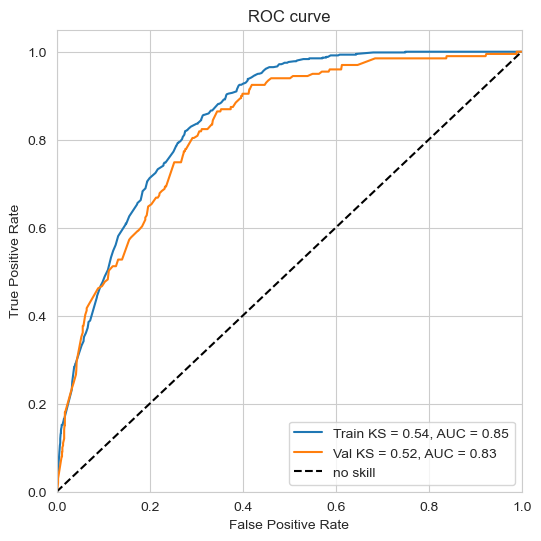

In [41]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
plot_auc2(ax, y_train, df_train['y_pred'], y_val, df_val['y_pred'],thresholds[ix])

### Variable Contribution

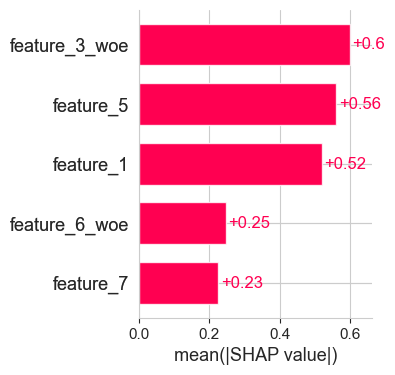

In [36]:
explainer = shap.Explainer(clf_lgb_new, X_train, feature_names=[list_lr])
shap_values = explainer(X_val)
fig = plt.figure()
shap.plots.bar(shap_values, max_display=20,show = False)
plt.gcf().set_size_inches(3,4)
plt.show()